# 1. Recogida y limpieza de datos

Importamos las librerías necesarias. Además, permitimos mostrar más columnas y filas para trabajar con comodidad.

In [1]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
import json
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', None)

Empezamos a extraer los datos de Understat con un ejemplo, el de La liga 2019/20.

In [2]:
url = 'https://understat.com/league/La_liga/2019'
res = requests.get(url)
soup = BeautifulSoup(res.content, "lxml")
scripts = soup.find_all('script')

In [3]:
#scripts

Adecuamos los datos, buscando las partes que nos interesan y eliminando el resto.

In [4]:
buscar_json = ''

#Buscamos los datos del equipo
for el in scripts:
    if 'teamsData' in str(el):
        buscar_json = str(el).strip()

#Adecuamos los valores encontrados
inicio = buscar_json.index("('")+2
fin = buscar_json.index("')")
json_data = buscar_json[inicio:fin]

json_data = json_data.encode('utf8').decode('unicode_escape')

In [5]:
#json_data

In [6]:
# Convertimos el json en un diccionario
data = json.loads(json_data)

In [7]:
#data

Obtenemos cada equipo con su ID correspondiente y el nombre de las columnas de lo que será nuestro DataFrame.

In [8]:
equipos = {}
for id in data.keys():
    equipos[id] = data[id]['title']

equipos

{'138': 'Sevilla',
 '140': 'Real Sociedad',
 '141': 'Espanyol',
 '142': 'Getafe',
 '143': 'Atletico Madrid',
 '146': 'Valencia',
 '147': 'Athletic Club',
 '148': 'Barcelona',
 '150': 'Real Madrid',
 '151': 'Levante',
 '152': 'Celta Vigo',
 '153': 'Real Betis',
 '154': 'Villarreal',
 '155': 'Granada',
 '156': 'Eibar',
 '157': 'Osasuna',
 '158': 'Alaves',
 '159': 'Leganes',
 '231': 'Real Valladolid',
 '239': 'Mallorca'}

In [9]:
columns = []
for id in data.keys():
    columns = list(data[id]['history'][0].keys())

columns

['h_a',
 'xG',
 'xGA',
 'npxG',
 'npxGA',
 'ppda',
 'ppda_allowed',
 'deep',
 'deep_allowed',
 'scored',
 'missed',
 'xpts',
 'result',
 'date',
 'wins',
 'draws',
 'loses',
 'pts',
 'npxGD']

In [10]:
# Obtenemos los datos de todos los equipos
tabla = {}
for id, equipo in equipos.items():
    datos_equipos = []
    for row in data[id]['history']:
        datos_equipos.append(list(row.values()))
    
    df = pd.DataFrame(datos_equipos, columns=columns)
    tabla[equipo] = df

In [11]:
#Mostramos un ejemplo de cómo quedaría hasta el momento
tabla["Valencia"].sample()

,h_a,xG,xGA,npxG,npxGA,ppda,ppda_allowed,deep,deep_allowed,scored,missed,xpts,result,date,wins,draws,loses,pts,npxGD
29,h,1.8991,1.60978,1.8991,1.60978,"{'att': 195, 'def': 17}","{'att': 362, 'def': 36}",2,4,2,0,1.6043,w,2020-06-21 17:30:00,1,0,0,3,0.28932


In [12]:
#Adecuamos los valores del PPDA y OPPDA
for equipo, df in tabla.items():
    tabla[equipo]['PPDA'] = tabla[equipo]['ppda'].apply(lambda x: x['att']/x['def'] if x['def'] != 0 else 0)
    tabla[equipo]['OPPDA'] = tabla[equipo]['ppda_allowed'].apply(lambda x: x['att']/x['def'] if x['def'] != 0 else 0)

#Mostramos cómo quedaría
tabla['Valencia'].sample()

,h_a,xG,xGA,npxG,npxGA,ppda,ppda_allowed,deep,deep_allowed,scored,missed,xpts,result,date,wins,draws,loses,pts,npxGD,PPDA,OPPDA
15,a,2.95856,2.12541,2.95856,1.38213,"{'att': 238, 'def': 17}","{'att': 310, 'def': 18}",8,4,4,2,1.9758,w,2019-12-07 17:30:00,1,0,0,3,1.57643,14.0,17.222222


Vamos a agrupar todos los valores de cada uno de los equipos de la liga. Según sean los datos, los sumamos o nos quedamos con el promedio.

In [13]:
sumar_columnas = ['xG', 'xGA', 'npxG', 'npxGA', 'deep', 'deep_allowed', 'scored', 'missed', 'xpts', 'wins', 'draws', 'loses', 'pts', 'npxGD']
promedio_columnas = ['PPDA', 'OPPDA']

In [14]:
frames = []
for equipo, df in tabla.items():
    datos_suma = pd.DataFrame(df[sumar_columnas].sum()).transpose()
    datos_media = pd.DataFrame(df[promedio_columnas].mean()).transpose()
    final_df = datos_suma.join(datos_media)
    final_df['team'] = equipo
    final_df['matches'] = len(df)
    frames.append(final_df)

datos_completos = pd.concat(frames)

datos_completos

,xG,xGA,npxG,npxGA,deep,deep_allowed,scored,missed,xpts,wins,draws,loses,pts,npxGD,PPDA,OPPDA,team,matches
0,55.155506,36.617301,49.952825,33.628775,238.0,148.0,54.0,34.0,65.7050,19.0,13.0,6.0,70.0,16.324050,8.411133,12.642357,Sevilla,38
0,50.915671,41.885105,47.199543,35.196378,231.0,192.0,56.0,48.0,57.1783,16.0,8.0,14.0,56.0,12.003165,8.649489,11.924641,Real Sociedad,38
0,37.002815,53.279324,34.029713,47.916092,148.0,191.0,27.0,58.0,41.7590,5.0,10.0,23.0,25.0,-13.886379,9.441301,10.059594,Espanyol,38
0,45.191234,43.023383,39.886634,38.563985,176.0,119.0,43.0,37.0,53.7878,14.0,12.0,12.0,54.0,1.322649,7.005995,6.302145,Getafe,38
0,58.700963,31.515192,52.739451,28.542603,264.0,162.0,51.0,27.0,72.3506,18.0,16.0,4.0,70.0,24.196848,9.686665,10.994450,Atletico Madrid,38
0,45.576255,59.073642,39.630147,52.384285,217.0,262.0,46.0,53.0,45.4291,14.0,11.0,13.0,53.0,-12.754138,14.086311,10.543273,Valencia,38
0,42.095595,52.419298,34.595139,47.216360,122.0,205.0,41.0,38.0,44.6548,13.0,12.0,13.0,51.0,-12.621221,9.713231,10.225018,Athletic Club,38
0,72.009449,37.823949,67.549781,32.620992,440.0,146.0,86.0,38.0,73.1381,25.0,7.0,6.0,82.0,34.928789,8.256988,17.961598,Barcelona,38
0,72.157218,33.146266,63.981449,31.659710,334.0,127.0,70.0,25.0,77.6868,26.0,9.0,3.0,87.0,32.321739,9.262202,14.476897,Real Madrid,38
0,49.427886,64.249355,45.711750,58.887593,177.0,273.0,47.0,53.0,42.8790,14.0,7.0,17.0,49.0,-13.175843,12.009367,8.825311,Levante,38


In [15]:
#Realizamos una serie de ajustes para mostrar mejor los datos
datos_completos = datos_completos[['team', 'matches', 'wins', 'draws', 'loses', 'scored', 'missed', 'pts', 'xG', 'npxG', 'xGA', 'npxGA', 'npxGD', 'PPDA', 'OPPDA', 'deep', 'deep_allowed', 'xpts']]
datos_completos.sort_values('pts', ascending=False, inplace=True)
datos_completos.reset_index(inplace=True, drop=True)
datos_completos['posición'] = range(1,len(datos_completos)+1)
datos_completos.columns = ["Equipo", "PJ", "G", "E", "P", "GF", "GC", "Pts", "xG", "npxG", "xGA", "npxGA", "npxGDif", 'PPDA', 'OPPDA', "Pases finales", "Pases finales permitidos", "xPts", "Posición"]
datos_completos["Pases finales"] = datos_completos["Pases finales"]/datos_completos["PJ"]
datos_completos["Pases finales permitidos"] = datos_completos["Pases finales permitidos"]/datos_completos["PJ"]
orden_columnas = ["Posición", "Equipo", "PJ", "G", "E", "P", "GF", "GC", "Pts", "xG", "npxG", "xGA", "npxGA", "npxGDif", 'PPDA', 'OPPDA', "Pases finales", "Pases finales permitidos", "xPts"]
datos_completos = datos_completos[orden_columnas]
datos_completos

,Posición,Equipo,PJ,G,E,P,GF,GC,Pts,xG,npxG,xGA,npxGA,npxGDif,PPDA,OPPDA,Pases finales,Pases finales permitidos,xPts
0,1,Real Madrid,38,26.0,9.0,3.0,70.0,25.0,87.0,72.157218,63.981449,33.146266,31.659710,32.321739,9.262202,14.476897,8.789474,3.342105,77.6868
1,2,Barcelona,38,25.0,7.0,6.0,86.0,38.0,82.0,72.009449,67.549781,37.823949,32.620992,34.928789,8.256988,17.961598,11.578947,3.842105,73.1381
2,3,Sevilla,38,19.0,13.0,6.0,54.0,34.0,70.0,55.155506,49.952825,36.617301,33.628775,16.324050,8.411133,12.642357,6.263158,3.894737,65.7050
3,4,Atletico Madrid,38,18.0,16.0,4.0,51.0,27.0,70.0,58.700963,52.739451,31.515192,28.542603,24.196848,9.686665,10.994450,6.947368,4.263158,72.3506
4,5,Villarreal,38,18.0,6.0,14.0,63.0,49.0,60.0,65.606501,57.430565,48.589865,41.832685,15.597880,10.900010,12.067332,5.736842,6.000000,64.0527
5,6,Real Sociedad,38,16.0,8.0,14.0,56.0,48.0,56.0,50.915671,47.199543,41.885105,35.196378,12.003165,8.649489,11.924641,6.078947,5.052632,57.1783
6,7,Granada,38,16.0,8.0,14.0,52.0,45.0,56.0,45.021407,41.305021,43.439237,39.723106,1.581915,10.176947,7.772832,3.552632,5.184211,52.5969
7,8,Getafe,38,14.0,12.0,12.0,43.0,37.0,54.0,45.191234,39.886634,43.023383,38.563985,1.322649,7.005995,6.302145,4.631579,3.131579,53.7878
8,9,Valencia,38,14.0,11.0,13.0,46.0,53.0,53.0,45.576255,39.630147,59.073642,52.384285,-12.754138,14.086311,10.543273,5.710526,6.894737,45.4291
9,10,Osasuna,38,13.0,13.0,12.0,46.0,54.0,52.0,49.038488,43.092265,49.580451,45.864071,-2.771806,9.097908,8.506952,5.184211,5.026316,51.5097


In [16]:
#Eliminamos algunos decimales innecesarios
columnas_enteros = ['Posición', 'PJ', 'G', 'E', 'P', 'GF', 'GC', 'Pts']
datos_completos[columnas_enteros] = datos_completos[columnas_enteros].astype(int)
pd.options.display.float_format = '{:,.2f}'.format

In [17]:
datos_completos

,Posición,Equipo,PJ,G,E,P,GF,GC,Pts,xG,npxG,xGA,npxGA,npxGDif,PPDA,OPPDA,Pases finales,Pases finales permitidos,xPts
0,1,Real Madrid,38,26,9,3,70,25,87,72.16,63.98,33.15,31.66,32.32,9.26,14.48,8.79,3.34,77.69
1,2,Barcelona,38,25,7,6,86,38,82,72.01,67.55,37.82,32.62,34.93,8.26,17.96,11.58,3.84,73.14
2,3,Sevilla,38,19,13,6,54,34,70,55.16,49.95,36.62,33.63,16.32,8.41,12.64,6.26,3.89,65.70
3,4,Atletico Madrid,38,18,16,4,51,27,70,58.70,52.74,31.52,28.54,24.20,9.69,10.99,6.95,4.26,72.35
4,5,Villarreal,38,18,6,14,63,49,60,65.61,57.43,48.59,41.83,15.60,10.90,12.07,5.74,6.00,64.05
5,6,Real Sociedad,38,16,8,14,56,48,56,50.92,47.20,41.89,35.20,12.00,8.65,11.92,6.08,5.05,57.18
6,7,Granada,38,16,8,14,52,45,56,45.02,41.31,43.44,39.72,1.58,10.18,7.77,3.55,5.18,52.60
7,8,Getafe,38,14,12,12,43,37,54,45.19,39.89,43.02,38.56,1.32,7.01,6.30,4.63,3.13,53.79
8,9,Valencia,38,14,11,13,46,53,53,45.58,39.63,59.07,52.38,-12.75,14.09,10.54,5.71,6.89,45.43
9,10,Osasuna,38,13,13,12,46,54,52,49.04,43.09,49.58,45.86,-2.77,9.10,8.51,5.18,5.03,51.51


## 2. Generalización y algunas aplicaciones

La siguiente función tiene dos parámetros de entrada:
- año: Hay que introducir el número entre comillas y se debe especificar el último año de la temporada. Por ejemplo, si queremos saber los datos de la temporada 2020/21, habrá que poner "2020".
- liga: Hay que poner el nombre de la liga entre paréntesis: "La liga", "Premier League", "Serie A", "Ligue 1", "Bundesliga" o "RFPL".

In [18]:
def clasificacion(liga, año):
    if liga == "La liga":
        liga = 'La_liga'
    elif liga == "Premier League":
        liga = 'EPL'
    elif liga == "Serie A":
        liga = "Serie_A"
    elif liga == "Ligue 1":
        liga = "Ligue_1"
    elif liga == "Bundesliga" or liga == "RFPL":
        pass
    else:
        return print("Seleccionar una de las siguientes ligas:\n Premier League \n La liga \n Serie A \n Ligue 1 \n Bundesliga \n RFPL")
    url = 'https://understat.com/league' + '/' + liga + '/' + año
    res = requests.get(url)
    soup = BeautifulSoup(res.content, "lxml")
    scripts = soup.find_all('script')

    buscar_json = ''
    for el in scripts:
        if 'teamsData' in str(el):
            buscar_json = str(el).strip()

    inicio = buscar_json.index("('")+2
    fin = buscar_json.index("')")
    json_data = buscar_json[inicio:fin]
    json_data = json_data.encode('utf8').decode('unicode_escape')
    
    data = json.loads(json_data)
    
    equipos = {}
    for id in data.keys():
        equipos[id] = data[id]['title']
    
    columns = []
    for id in data.keys():
        columns = list(data[id]['history'][0].keys())
    
    tabla = {}
    for id, equipo in equipos.items():
        datos_equipos = []
        for row in data[id]['history']:
            datos_equipos.append(list(row.values()))

        df = pd.DataFrame(datos_equipos, columns=columns)
        tabla[equipo] = df
        
    for equipo, df in tabla.items():
        tabla[equipo]['PPDA'] = tabla[equipo]['ppda'].apply(lambda x: x['att']/x['def'] if x['def'] != 0 else 0)
        tabla[equipo]['OPPDA'] = tabla[equipo]['ppda_allowed'].apply(lambda x: x['att']/x['def'] if x['def'] != 0 else 0)
    
    sumar_columnas = ['xG', 'xGA', 'npxG', 'npxGA', 'deep', 'deep_allowed', 'scored', 'missed', 'xpts', 'wins', 'draws', 'loses', 'pts', 'npxGD']
    promedio_columnas = ['PPDA', 'OPPDA']
    
    frames = []
    for equipo, df in tabla.items():
        datos_suma = pd.DataFrame(df[sumar_columnas].sum()).transpose()
        datos_media = pd.DataFrame(df[promedio_columnas].mean()).transpose()
        final_df = datos_suma.join(datos_media)
        final_df['team'] = equipo
        final_df['matches'] = len(df)
        frames.append(final_df)

    datos_completos = pd.concat(frames)

    datos_completos = datos_completos[['team', 'matches', 'wins', 'draws', 'loses', 'scored', 'missed', 'pts', 'xG', 'npxG', 'xGA', 'npxGA', 'npxGD', 'PPDA', 'OPPDA', 'deep', 'deep_allowed', 'xpts']]
    datos_completos.sort_values('pts', ascending=False, inplace=True)
    datos_completos.reset_index(inplace=True, drop=True)
    datos_completos['posición'] = range(1,len(datos_completos)+1)
    datos_completos.columns = ["Equipo", "PJ", "G", "E", "P", "GF", "GC", "Pts", "xG", "npxG", "xGA", "npxGA", "npxGDif", 'PPDA', 'OPPDA', "Pases finales", "Pases finales permitidos", "xPts", "Posición"]
    datos_completos["Pases finales"] = datos_completos["Pases finales"]/datos_completos["PJ"]
    datos_completos["Pases finales permitidos"] = datos_completos["Pases finales permitidos"]/datos_completos["PJ"]
    orden_columnas = ["Posición", "Equipo", "PJ", "G", "E", "P", "GF", "GC", "Pts", "xG", "npxG", "xGA", "npxGA", "npxGDif", 'PPDA', 'OPPDA', "Pases finales", "Pases finales permitidos", "xPts"]
    datos_completos = datos_completos[orden_columnas]

    columnas_enteros = ['Posición', 'PJ', 'G', 'E', 'P', 'GF', 'GC', 'Pts']
    datos_completos[columnas_enteros] = datos_completos[columnas_enteros].astype(int)
    pd.options.display.float_format = '{:,.2f}'.format

    return datos_completos

In [19]:
#Mostramos un ejemplo
clasificacion("La liga", "2020")

,Posición,Equipo,PJ,G,E,P,GF,GC,Pts,xG,npxG,xGA,npxGA,npxGDif,PPDA,OPPDA,Pases finales,Pases finales permitidos,xPts
0,1,Atletico Madrid,20,16,3,1,42,12,51,31.20,26.59,16.60,15.85,10.73,10.91,13.55,7.10,4.30,37.44
1,2,Real Madrid,22,14,4,4,39,19,46,39.73,38.24,23.09,17.88,20.36,9.82,15.27,8.36,3.59,41.08
2,3,Barcelona,21,13,4,4,44,20,43,48.17,44.45,23.84,22.35,22.10,10.90,17.50,12.95,4.33,42.77
3,4,Sevilla,21,13,3,5,31,16,42,32.41,29.43,19.23,16.97,12.47,7.66,16.06,6.86,3.10,38.46
4,5,Villarreal,22,8,12,2,31,22,36,32.56,27.35,19.84,16.86,10.49,10.65,12.69,6.73,4.23,40.47
5,6,Real Sociedad,22,9,8,5,36,20,35,39.18,33.23,20.39,18.16,15.07,8.13,13.39,8.36,3.45,42.03
6,7,Granada,22,8,6,8,26,36,30,23.28,21.06,35.22,30.47,-9.41,13.15,7.16,3.23,6.09,23.44
7,8,Real Betis,22,9,3,10,29,37,30,28.14,24.40,32.61,27.41,-3.01,9.39,11.15,5.36,4.77,28.81
8,9,Levante,21,6,9,6,31,31,27,27.76,24.79,27.76,26.27,-1.49,8.89,11.75,7.05,6.29,28.45
9,10,Celta Vigo,22,6,8,8,26,33,26,32.29,30.06,24.69,22.46,7.61,7.74,11.27,5.91,4.50,35.38


### 2.1. Comparativa PPDA y OPPDA
En el siguiente apartado se realizará la comparativa de los PPDA y OPPDA, en un campeonato determinado y en una temporada concreta.
La función "comparación" recoge los datos de la liga y de la temporada especificada, con los mismos parámetros que en la función "clasificacion", y muestra en el eje X los PPDA y en el eje Y los OPPDA. Además, muestra en tamaño los puntos de cada equipo y por color el puesto que ocupan en la clasificación.

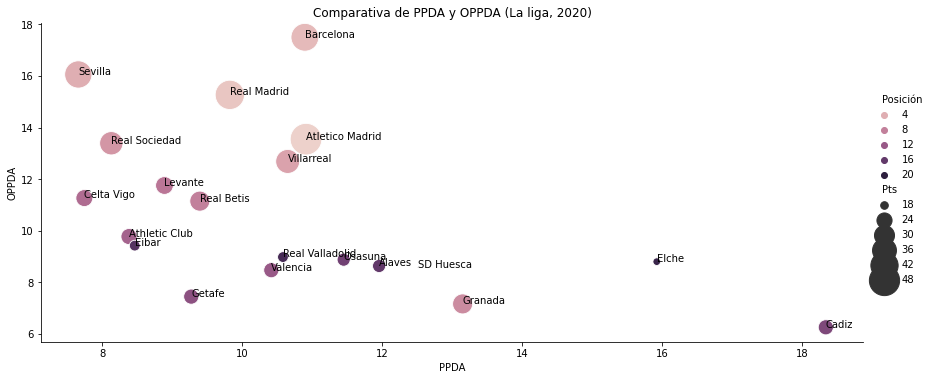

In [20]:
#Esta función sirve para establecer las etiquetas en cada punto del gráfico.
def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'], point['y'], str(point['val']))

def comparacion (liga, año):         
    tabla = clasificacion(liga, año)
    ax = sns.relplot(x=tabla.PPDA, y=tabla.OPPDA, size=tabla.Pts, sizes=(1, 1000), data=tabla, hue=tabla.Posición, aspect = 24/10)
    plt.title('Comparativa de PPDA y OPPDA (' + liga + ', ' + año + ')')
    label_point(tabla.PPDA, tabla.OPPDA, tabla.Equipo, plt.gca())
    return plt.show()

comparacion("La liga", "2020")

### 2.2. Comparación por competición
Para empezar vemos un ejemplo de cómo concatenar todas las clasificaciones de la temporada 2019/20, añadiendo una nueva columna: la competición.

In [21]:
Premier_2019 = clasificacion("Premier League", "2019")
Premier_2019["Competición"]="Premier League"
Liga_2019 = clasificacion("La liga", "2019")
Liga_2019["Competición"]="La liga"
SerieA_2019 = clasificacion("Serie A", "2019")
SerieA_2019["Competición"]="Serie A"
Bundesliga_2019 = clasificacion("Bundesliga", "2019")
Bundesliga_2019["Competición"]="Bundesliga"
RFPL_2019 = clasificacion("RFPL", "2019")
RFPL_2019["Competición"]="RFPL"
Ligue1_2019 = clasificacion("Ligue 1", "2019")
Ligue1_2019["Competición"]="Ligue 1"
Todas_2019 = pd.concat([Premier_2019, Liga_2019, SerieA_2019, Bundesliga_2019, RFPL_2019, Ligue1_2019])
Todas_2019

,Posición,Equipo,PJ,G,E,P,GF,GC,Pts,xG,npxG,xGA,npxGA,npxGDif,PPDA,OPPDA,Pases finales,Pases finales permitidos,xPts,Competición
0,1,Liverpool,38,32,3,3,85,33,99,75.19,71.39,39.57,38.81,32.58,8.61,24.74,11.29,3.82,74.28,Premier League
1,2,Manchester City,38,26,3,9,102,35,81,102.21,93.53,37.00,34.71,58.82,9.31,25.49,14.39,3.55,86.76,Premier League
2,3,Manchester United,38,18,12,8,66,36,66,66.19,55.53,38.06,35.78,19.75,10.47,12.81,7.63,4.68,70.99,Premier League
3,4,Chelsea,38,20,6,12,69,54,66,76.23,70.90,41.09,39.57,31.33,9.69,16.61,8.58,4.45,73.49,Premier League
4,5,Leicester,38,18,8,12,67,41,62,61.02,55.67,47.89,40.28,15.39,9.12,14.20,7.71,5.34,61.16,Premier League
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,16,Dijon,28,7,9,12,27,37,30,27.38,26.62,39.30,38.54,-11.92,14.31,9.70,3.96,6.29,31.19,Ligue 1
16,17,Saint-Etienne,28,8,6,14,29,45,30,29.65,25.85,37.73,33.17,-7.31,10.72,10.50,3.32,4.75,32.68,Ligue 1
17,18,Nimes,28,7,6,15,29,44,27,30.19,28.67,40.47,37.43,-8.76,12.46,9.05,3.89,5.68,32.69,Ligue 1
18,19,Amiens,28,4,11,13,31,50,23,25.62,21.69,38.43,37.67,-15.97,12.45,9.92,3.61,5.29,32.84,Ligue 1


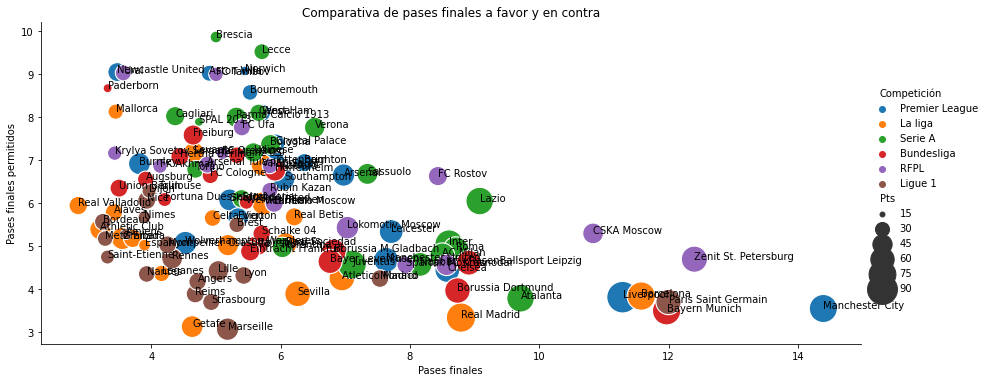

In [22]:
#Vemos un ejemplo comparando los pases finales a favor y en contra.
ax = sns.relplot(x=Todas_2019["Pases finales"], y=Todas_2019["Pases finales permitidos"], size=Todas_2019.Pts, sizes=(1, 1000), data=Todas_2019, hue=Todas_2019.Competición, aspect = 24/10)
plt.title('Comparativa de pases finales a favor y en contra')
label_point(Todas_2019["Pases finales"], Todas_2019["Pases finales permitidos"], Todas_2019.Equipo, plt.gca())   
plt.show()

En esta función, especificando el año entre paréntesis con las mismas características que antes, se devuelve la comparativa de todas las competiciones entre los pases decisivos tanto a favor como en contra, diferenciando por tamaño la cantidad de puntos de cada equipo y por color la competición a la que pertenecen.

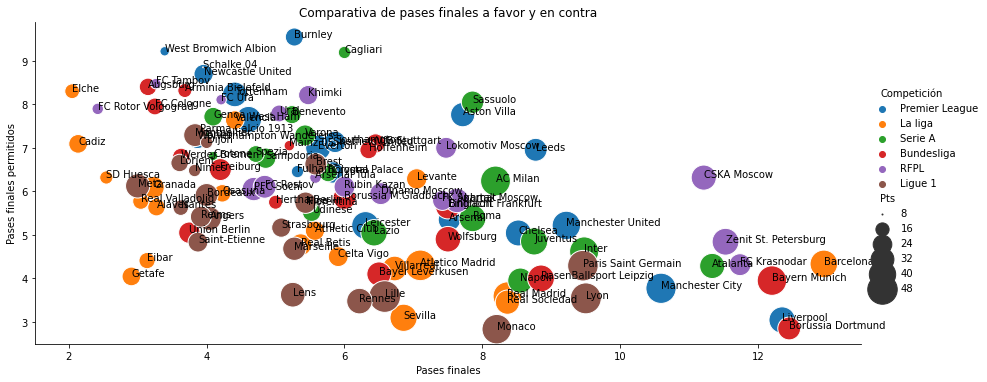

In [23]:
def competiciones_pases(año):
    Premier = clasificacion("Premier League", año)
    Premier["Competición"]="Premier League"
    Liga = clasificacion("La liga", año)
    Liga["Competición"]="La liga"
    SerieA = clasificacion("Serie A", año)
    SerieA["Competición"]="Serie A"
    Bundesliga = clasificacion("Bundesliga", año)
    Bundesliga["Competición"]="Bundesliga"
    RFPL = clasificacion("RFPL", año)
    RFPL["Competición"]="RFPL"
    Ligue1 = clasificacion("Ligue 1", año)
    Ligue1["Competición"]="Ligue 1"
    Todas = pd.concat([Premier, Liga, SerieA, Bundesliga, RFPL, Ligue1])
    
    ax = sns.relplot(x=Todas["Pases finales"], y=Todas["Pases finales permitidos"], size=Todas.Pts, sizes=(1, 1000), data=Todas, hue=Todas.Competición, aspect = 24/10)
    plt.title('Comparativa de pases finales a favor y en contra')
    label_point(Todas["Pases finales"], Todas["Pases finales permitidos"], Todas.Equipo, plt.gca())   

    return plt.show()

competiciones_pases("2020")

Función similar a la anterior, pero con los goles esperados a favor y en contra.

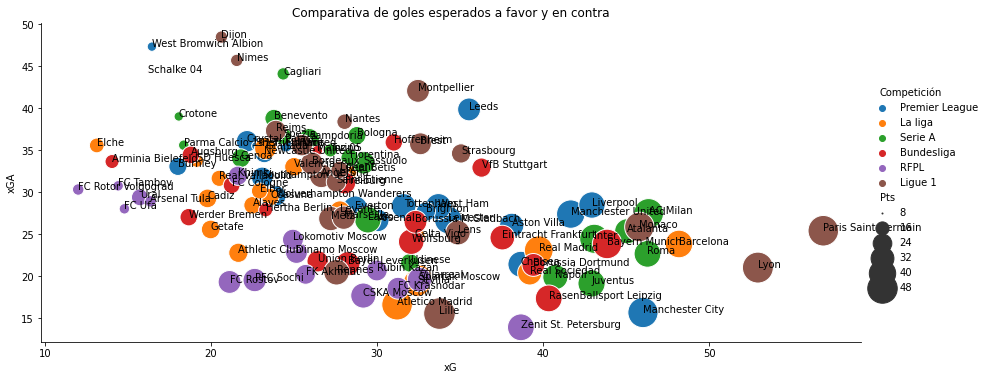

In [24]:
def competiciones_xg(año):
    Premier = clasificacion("Premier League", año)
    Premier["Competición"]="Premier League"
    Liga = clasificacion("La liga", año)
    Liga["Competición"]="La liga"
    SerieA = clasificacion("Serie A", año)
    SerieA["Competición"]="Serie A"
    Bundesliga = clasificacion("Bundesliga", año)
    Bundesliga["Competición"]="Bundesliga"
    RFPL = clasificacion("RFPL", año)
    RFPL["Competición"]="RFPL"
    Ligue1 = clasificacion("Ligue 1", año)
    Ligue1["Competición"]="Ligue 1"
    Todas = pd.concat([Premier, Liga, SerieA, Bundesliga, RFPL, Ligue1])
    
    ax = sns.relplot(x=Todas["xG"], y=Todas["xGA"], size=Todas.Pts, sizes=(1, 1000), data=Todas, hue=Todas.Competición, aspect = 24/10)
    plt.title('Comparativa de goles esperados a favor y en contra')
    label_point(Todas["xG"], Todas["xGA"], Todas.Equipo, plt.gca())   

    return plt.show()

competiciones_xg("2020")

En esta función se muestra la comparativa de PPDA tanto del equipo propio como del rival, pero diferenciando según la competición a la que pertenezcan los equipos.

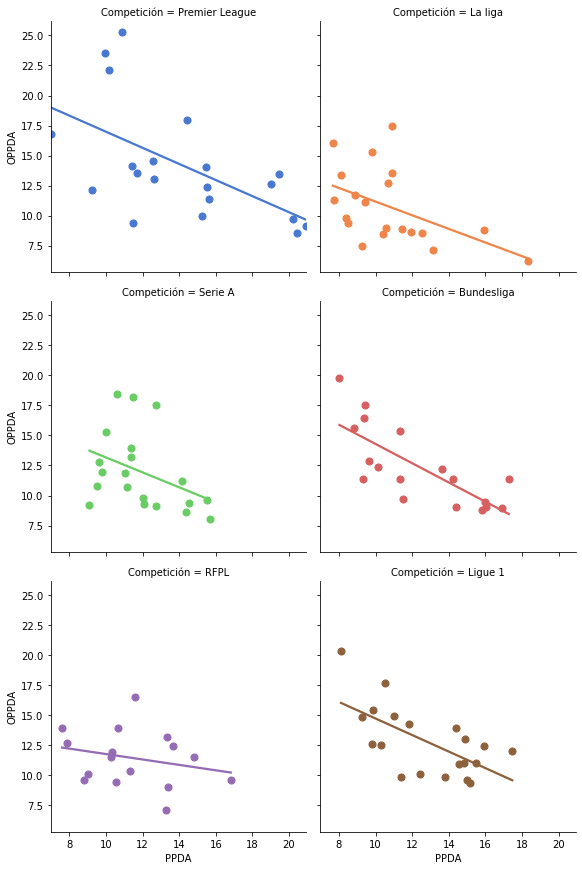

In [25]:
def competiciones_ppda(año):
    Premier = clasificacion("Premier League", año)
    Premier["Competición"]="Premier League"
    Liga = clasificacion("La liga", año)
    Liga["Competición"]="La liga"
    SerieA = clasificacion("Serie A", año)
    SerieA["Competición"]="Serie A"
    Bundesliga = clasificacion("Bundesliga", año)
    Bundesliga["Competición"]="Bundesliga"
    RFPL = clasificacion("RFPL", año)
    RFPL["Competición"]="RFPL"
    Ligue1 = clasificacion("Ligue 1", año)
    Ligue1["Competición"]="Ligue 1"
    Todas = pd.concat([Premier, Liga, SerieA, Bundesliga, RFPL, Ligue1])
    
    sns.lmplot(x="PPDA", y="OPPDA", col="Competición", hue="Competición", data=Todas,
           col_wrap=2, ci=None, palette="muted", height=4,
           scatter_kws={"s": 50, "alpha": 1})
    
    return plt.show()

competiciones_ppda("2020")

Por último, se puede ampliar los datos de la clasificación para establecer otro tipo de gráficos o de análisis estadísticos.

In [26]:
def clasificacion_completa(liga, año):
    df = clasificacion(liga, año)
    df["xG_Dif"] = df["xG"] - df["GF"]
    df["xGA_Dif"] = df["xGA"] - df["GC"]
    df["xPts_Dif"] = df["xPts"] - df["Pts"]
    df["Pts_PJ"] = df["Pts"]/df["PJ"]
    return df

clasificacion_completa("La liga", "2019")

,Posición,Equipo,PJ,G,E,P,GF,GC,Pts,xG,npxG,xGA,npxGA,npxGDif,PPDA,OPPDA,Pases finales,Pases finales permitidos,xPts,xG_Dif,xGA_Dif,xPts_Dif,Pts_PJ
0,1,Real Madrid,38,26,9,3,70,25,87,72.16,63.98,33.15,31.66,32.32,9.26,14.48,8.79,3.34,77.69,2.16,8.15,-9.31,2.29
1,2,Barcelona,38,25,7,6,86,38,82,72.01,67.55,37.82,32.62,34.93,8.26,17.96,11.58,3.84,73.14,-13.99,-0.18,-8.86,2.16
2,3,Sevilla,38,19,13,6,54,34,70,55.16,49.95,36.62,33.63,16.32,8.41,12.64,6.26,3.89,65.70,1.16,2.62,-4.30,1.84
3,4,Atletico Madrid,38,18,16,4,51,27,70,58.70,52.74,31.52,28.54,24.20,9.69,10.99,6.95,4.26,72.35,7.70,4.52,2.35,1.84
4,5,Villarreal,38,18,6,14,63,49,60,65.61,57.43,48.59,41.83,15.60,10.90,12.07,5.74,6.00,64.05,2.61,-0.41,4.05,1.58
5,6,Real Sociedad,38,16,8,14,56,48,56,50.92,47.20,41.89,35.20,12.00,8.65,11.92,6.08,5.05,57.18,-5.08,-6.11,1.18,1.47
6,7,Granada,38,16,8,14,52,45,56,45.02,41.31,43.44,39.72,1.58,10.18,7.77,3.55,5.18,52.60,-6.98,-1.56,-3.40,1.47
7,8,Getafe,38,14,12,12,43,37,54,45.19,39.89,43.02,38.56,1.32,7.01,6.30,4.63,3.13,53.79,2.19,6.02,-0.21,1.42
8,9,Valencia,38,14,11,13,46,53,53,45.58,39.63,59.07,52.38,-12.75,14.09,10.54,5.71,6.89,45.43,-0.42,6.07,-7.57,1.39
9,10,Osasuna,38,13,13,12,46,54,52,49.04,43.09,49.58,45.86,-2.77,9.10,8.51,5.18,5.03,51.51,3.04,-4.42,-0.49,1.37


### 2.3. Obtener todos los datos
A continuación vamos a recopilar todas las clasificaciones, desde la temporada 2014/15 hasta la actualidad y de las 6 ligas citadas inicialmente. Como se puede comprobar, se ha añadido una nueva columna llamada EquiposCompeticion, que resulta de añadir la temporada al lado del nombre del equipo, para que se puedan establecer las comparaciones futuras.

In [27]:
base_url = 'https://understat.com/league'
ligas = ['La liga', 'Premier League', 'Serie A', 'Bundesliga', 'Ligue 1', 'RFPL']
temporadas = ['2014', '2015', '2016', '2017', '2018', '2019', '2020']

datos_ligas = dict()
for liga in ligas:
    datos_temporadas = dict()
    for temporada in temporadas:     
        datos_temporadas[temporada] = clasificacion_completa(liga, temporada)
        datos_temporadas[temporada]["EquipoCompeticion"] = datos_temporadas[temporada]["Equipo"] + ' ' + temporada + '/' + str(int(temporada[2:])+1)
        df_temporadas = pd.concat(datos_temporadas)
    datos_ligas[liga] = df_temporadas

ligas_completas = pd.concat(datos_ligas)

In [28]:
ligas_completas

Posición              Equipo  PJ   G   E   P   GF  GC  Pts  \
La liga 2014 0          1           Barcelona  38  30   4   4  110  21   94   
             1          2         Real Madrid  38  30   2   6  118  38   92   
             2          3     Atletico Madrid  38  23   9   6   67  29   78   
             3          4            Valencia  38  22  11   5   70  32   77   
             4          5             Sevilla  38  23   7   8   71  45   76   
...                   ...                 ...  ..  ..  ..  ..  ...  ..  ...   
RFPL    2020 11        12                Ural  19   4   9   6   16  23   21   
             12        13        Arsenal Tula  19   3   5  11   17  30   14   
             13        14  FC Rotor Volgograd  19   3   5  11    9  30   14   
             14        15              FC Ufa  19   3   4  12   14  31   13   
             15        16           FC Tambov  19   3   4  12   13  29   13   

                    xG  npxG   xGA  npxGA  npxGDif  PPDA  OPPDA  \
La liga 2014 0  102.98 97.78 28.44  24.73    73.05  5.68  16.37   
             1   95.77 86.10 42.61  38.89    47.21 10.21  12.93   
             2   57.05 52.59 29.07  26.84    25.75  8.98   9.24   
             3   55.06 49.70 39.39  33.45    16.26  8.71   7.87   
             4   69.53 62.09 47.86  41.92    20.18  8.28   9.48   
...                ...   ...   ...    ...      ...   ...    ...   
RFPL    2020 11  15.72 12.71 29.40  24.09   -11.39 13.31  13.22   
             12  16.36 15.61 28.92  24.39    -8.79 10.53   9.47   
             13  12.01  9.58 30.33  25.05   -15.46 13.26   7.14   
             14  14.79 12.53 28.03  24.24   -11.71 14.78  11.57   
             15  14.42 10.63 30.77  27.71   -17.08 16.82   9.59   

                 Pases finales  Pases finales permitidos  xPts  xG_Dif  \
La liga 2014 0           12.87                      3.00 94.08   -7.02   
             1            9.24                      4.03 81.75  -22.23   
             2            5.18                      3.24 73.14   -9.95   
             3            5.34                      4.53 63.71  -14.94   
             4            8.03                      4.42 67.39   -1.47   
...                        ...                       ...   ...     ...   
RFPL    2020 11           5.05                      7.79 18.74   -0.28   
             12           5.58                      6.32 18.30   -0.64   
             13           2.42                      7.89 13.36    3.01   
             14           4.21                      8.11 18.48    0.79   
             15           3.26                      8.47 15.58    1.42   

                 xGA_Dif  xPts_Dif  Pts_PJ           EquipoCompeticion  
La liga 2014 0      7.44      0.08    2.47           Barcelona 2014/15  
             1      4.61    -10.25    2.42         Real Madrid 2014/15  
             2      0.07     -4.86    2.05     Atletico Madrid 2014/15  
             3      7.39    -13.29    2.03            Valencia 2014/15  
             4      2.86     -8.61    2.00             Sevilla 2014/15  
...                  ...       ...     ...                         ...  
RFPL    2020 11     6.40     -2.26    1.11                Ural 2020/21  
             12    -1.08      4.30    0.74        Arsenal Tula 2020/21  
             13     0.33     -0.64    0.74  FC Rotor Volgograd 2020/21  
             14    -2.97      5.48    0.68              FC Ufa 2020/21  
             15     1.77      2.58    0.68           FC Tambov 2020/21  

[798 rows x 24 columns]

In [29]:
#Se pueden extraer clasificaciones concretas de los datos completos. Por ejemplo, la liga de la temporada 2016/17
ligas_completas.loc["La liga"].loc["2016"]

,Posición,Equipo,PJ,G,E,P,GF,GC,Pts,xG,npxG,xGA,npxGA,npxGDif,PPDA,OPPDA,Pases finales,Pases finales permitidos,xPts,xG_Dif,xGA_Dif,xPts_Dif,Pts_PJ,EquipoCompeticion
0,1,Real Madrid,38,29,6,3,106,41,93,90.87,84.92,36.86,33.89,51.03,9.74,13.41,8.76,4.55,86.17,-15.13,-4.14,-6.83,2.45,Real Madrid 2016/17
1,2,Barcelona,38,28,6,4,116,37,90,93.55,86.86,31.32,31.32,55.55,6.70,15.71,14.53,3.79,87.95,-22.45,-5.68,-2.05,2.37,Barcelona 2016/17
2,3,Atletico Madrid,38,23,9,6,70,27,78,60.66,54.53,31.34,28.36,26.17,9.95,8.83,6.97,4.42,69.10,-9.34,4.34,-8.90,2.05,Atletico Madrid 2016/17
3,4,Sevilla,38,21,9,8,69,49,72,59.09,55.27,38.70,34.87,20.40,6.98,10.79,8.89,5.29,66.18,-9.91,-10.30,-5.82,1.89,Sevilla 2016/17
4,5,Villarreal,38,19,10,9,56,33,67,52.23,46.28,43.16,38.70,7.58,11.53,10.59,7.05,6.84,59.57,-3.77,10.16,-7.43,1.76,Villarreal 2016/17
5,6,Real Sociedad,38,19,7,12,59,53,64,45.58,39.64,43.71,38.38,1.26,7.10,11.22,6.03,4.42,54.94,-13.42,-9.29,-9.06,1.68,Real Sociedad 2016/17
6,7,Athletic Club,38,19,6,13,53,43,63,51.08,45.14,40.46,37.97,7.17,7.99,9.94,6.13,4.39,60.54,-1.92,-2.54,-2.46,1.66,Athletic Club 2016/17
7,8,Espanyol,38,15,11,12,49,50,56,32.55,29.58,38.35,36.86,-7.28,11.62,8.02,3.08,6.68,46.92,-16.45,-11.65,-9.08,1.47,Espanyol 2016/17
8,9,Alaves,38,14,13,11,41,43,55,42.60,39.63,43.97,39.51,0.12,12.40,7.92,2.89,6.53,52.79,1.60,0.97,-2.21,1.45,Alaves 2016/17
9,10,Eibar,38,15,9,14,56,51,54,42.98,36.89,45.17,40.71,-3.82,7.82,9.46,4.13,5.74,50.05,-13.02,-5.83,-3.95,1.42,Eibar 2016/17


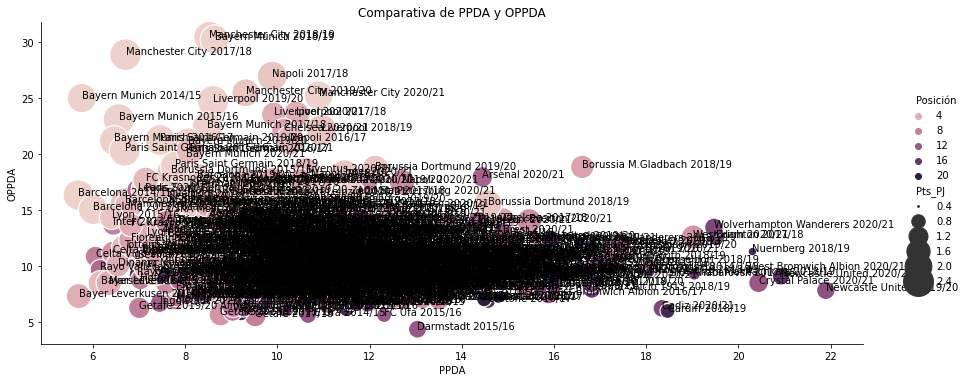

In [30]:
#Realizamos la comparativa entre PPDA y OPPDA de todas las ligas
ax = sns.relplot(x=ligas_completas.PPDA, y=ligas_completas.OPPDA, size=ligas_completas.Pts_PJ, sizes=(1, 1000), data=ligas_completas, hue=ligas_completas.Posición, aspect = 24/10)
plt.title('Comparativa de PPDA y OPPDA')
label_point(ligas_completas.PPDA, ligas_completas.OPPDA, ligas_completas.EquipoCompeticion, plt.gca())

In [31]:
def comparacion_equipos(n, equipos):
    if n == 1:
        df = ligas_completas[ligas_completas['EquipoCompeticion'].str.contains(equipos, case=False)]
        ax = sns.relplot(x=df.PPDA, y=df.OPPDA, size=df.Pts_PJ, sizes=(100, 1000), data=df, hue=df.Posición, aspect = 24/10)
        plt.title('Comparativa de PPDA y OPPDA')
        label_point(df.PPDA, df.OPPDA, df.EquipoCompeticion, plt.gca())
    else:
        for i in range(1,n+1):
            if i == 1:
                df = ligas_completas[ligas_completas['EquipoCompeticion'].str.contains(equipos[i-1], case=False)]
            else:
                aux = ligas_completas[ligas_completas['EquipoCompeticion'].str.contains(equipos[i-1], case=False)]
                df = pd.concat([aux,df])
        ax = sns.relplot(x=df.PPDA, y=df.OPPDA, size=df.Pts_PJ, sizes=(100, 1000), data=df, hue=df.Equipo, aspect = 24/10)
        plt.title('Comparativa de PPDA y OPPDA')
        label_point(df.PPDA, df.OPPDA, df.EquipoCompeticion, plt.gca())
    return plt.show()

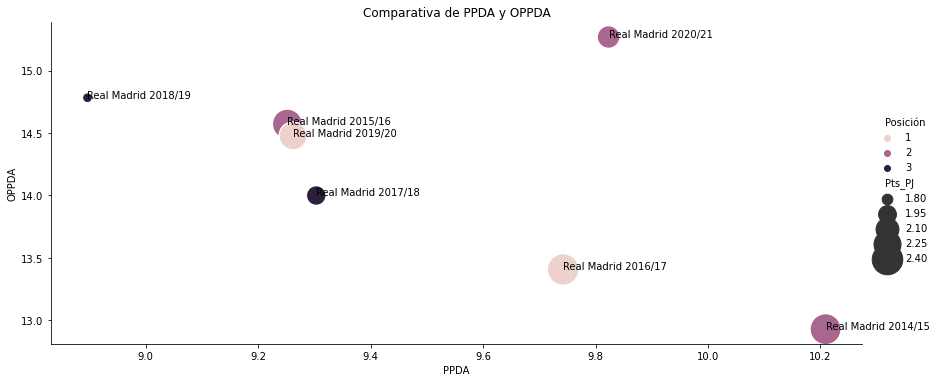

In [32]:
#Hacemos una comparación de un solo equipo a lo largo de sus temporadas
comparacion_equipos(1, "Real Madrid")

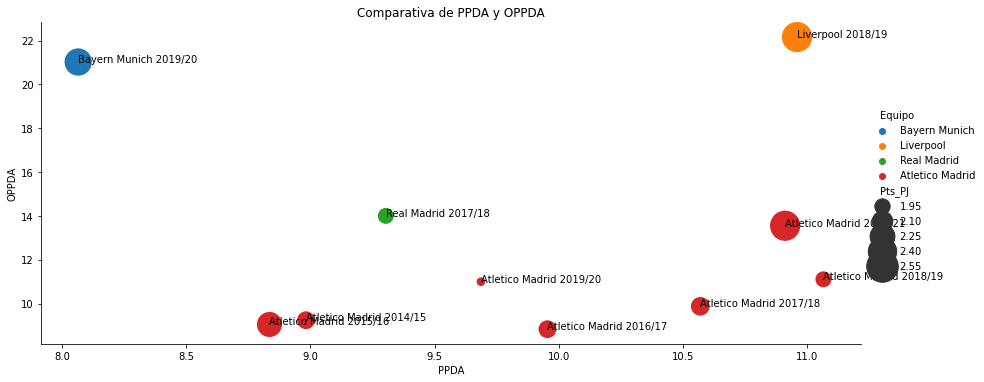

In [33]:
#Se pueden comparar varios equipos y de temporadas concretas
comparacion_equipos(4, ("Atleti", "Real Madrid 2017/18", "Liverpool 2018/19", "Bayern Munich 2019/20"))